# Ghana AI Hackathon Project
This notebook contains the implementation for the Ghana AI Hackathon. The goal of the project is to [briefly state the purpose: e.g., detect malaria from images, predict crop yields, etc.].

## Team Members
- Eldad Opare
- Fadzai Zaranyika
- Nana Kwaku Daasebre
- Vanessa logan

## Table of Contents
1. Introduction
2. Data Loading and Exploration
3. Data Preprocessing
4. Model Building
5. Evaluation
6. Conclusion and Future Work


# Package Importations and Installations

In [ ]:
import os
import sys
import re
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import matplotlib.image as mpimg
from collections import defaultdict
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout


# Dataset Unpacking


In [ ]:
!wget -c "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/bwh3zbpkpv-1.zip" -O CCMT_raw.zip

In [ ]:
!unzip CCMT_raw.zip -d CCMT_both_augmented_raw

### For storage efficiency, tiny chunks of code like the one below were made to delete folders that are no longer relevant from time to time

In [ ]:
# Removing the CCMT_raw.zip file
if os.path.exists('/content/CCMT_raw.zip'):
    os.remove('/content/CCMT_raw.zip')

# Merging the train and test set from the Augmented Dataset to from one main augmented set


The merge_augmented_dataset function merges an augmented dataset of crop pests and diseases by combining training and test sets while intelligently handling variant naming conventions. It processes each crop category separately, identifies disease variants across both train and test sets using regex pattern matching (removing trailing numbers to find base disease names), and consolidates all variants under unified directories in the target location.

The implementation carefully handles filename conflicts by appending counters to duplicates (e.g., "image_1.jpg"), preserves file metadata during copying using shutil.copy2(), and maintains the original directory structure.

The function automatically creates necessary target directories and skips any missing subdirectories, making it robust against incomplete datasets. Designed for agricultural image datasets where disease variants are numerically suffixed (e.g., "blight1", "blight2"), it outputs a reorganized dataset where all variants of the same disease are grouped together under their base names, facilitating easier model training with consolidated data. The default paths assume a specific project structure but can be customized via parameters. Progress is logged by printing each processed crop category.

In [ ]:
def merge_crops_diseases_by_base_name(source_dir='CCMT_both_augmented_raw/Dataset for Crop Pest and Disease Detection/CCMT Dataset-Augmented', target_dir='Merged_Crop_Augmented_Data'):
    os.makedirs(target_dir, exist_ok=True)

    for crop in os.listdir(source_dir):
        crop_source_path = os.path.join(source_dir, crop)
        if not os.path.isdir(crop_source_path):
            continue

        print(f"Processing crop: {crop}")
        crop_target_path = os.path.join(target_dir, crop)
        os.makedirs(crop_target_path, exist_ok=True)

        disease_map = defaultdict(list)

        for split in ['train_set', 'test_set']:
            split_path = os.path.join(crop_source_path, split)
            if not os.path.isdir(split_path):
                continue


            for disease_folder in os.listdir(split_path):
                disease_path = os.path.join(split_path, disease_folder)
                if not os.path.isdir(disease_path):
                    continue

                base_name = re.sub(r'\d+$', '', disease_folder).strip()

                base_name = base_name.title()


                disease_map[base_name].append(disease_path)


        for disease_name, variant_paths in disease_map.items():
            target_disease_folder = os.path.join(crop_target_path, disease_name)
            os.makedirs(target_disease_folder, exist_ok=True)

            copied_files = set()

            for variant_path in variant_paths:
                for filename in os.listdir(variant_path):
                    source_file = os.path.join(variant_path, filename)
                    if not os.path.isfile(source_file):
                        continue

                    new_filename = filename
                    if filename in copied_files:
                        base, ext = os.path.splitext(filename)
                        counter = 1
                        while f"{base}_{counter}{ext}" in copied_files:
                            counter += 1
                        new_filename = f"{base}_{counter}{ext}"
                    target_file = os.path.join(target_disease_folder, new_filename)
                    shutil.copy2(source_file, target_file)
                    copied_files.add(new_filename)

        print(f"Finished processing crop: {crop}")


merge_crops_diseases_by_base_name()

print("Merging of datasets by disease completed successfully!")

# Getting the Raw Dataset

In [ ]:
def move_crop_folders(source_dir, target_dir):
    os.makedirs(target_dir, exist_ok=True)
    for item in os.listdir(source_dir):
        source_path = os.path.join(source_dir, item)
        target_path = os.path.join(target_dir, item)
        if os.path.isdir(source_path):
            shutil.move(source_path, target_path)
            print(f"Moved {source_path} to {target_path}")

source_dir = 'CCMT_both_augmented_raw/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset'
target_dir = 'Crop_Raw_Data'

move_crop_folders(source_dir, target_dir)

Moved CCMT_both_augmented_raw/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Tomato to Crop_Raw_Data/Tomato
Moved CCMT_both_augmented_raw/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Maize to Crop_Raw_Data/Maize
Moved CCMT_both_augmented_raw/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Cassava to Crop_Raw_Data/Cassava
Moved CCMT_both_augmented_raw/Dataset for Crop Pest and Disease Detection/Raw Data/CCMT Dataset/Cashew to Crop_Raw_Data/Cashew


In [ ]:
# Remove CCMT_raw
if os.path.exists('/content/CCMT_both_augmented_raw'):
    shutil.rmtree('/content/CCMT_both_augmented_raw')

# Data Preprocessing

## Filtering off blurry images using the Laplacian variance

In [ ]:
def get_all_image_paths(dataset_path):
    """Get all image paths recursively from a directory"""
    image_paths = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths


In [ ]:
def calculate_sharpness_scores(image_paths):
    """Calculate Laplacian variance for all images"""
    blur_scores = []
    valid_paths = []

    print("\nCalculating sharpness scores...")
    for img_path in tqdm(image_paths):
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            lap_var = cv2.Laplacian(img, cv2.CV_64F).var()
            blur_scores.append(lap_var)
            valid_paths.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")

    return np.array(blur_scores), valid_paths


In [ ]:
def analyze_sharpness_distribution(scores):
    """Generate statistics and histogram of sharpness scores"""
    stats = {
        'min': np.min(scores),
        'max': np.max(scores),
        'mean': np.mean(scores),
        'median': np.median(scores),
        'std': np.std(scores)
    }

    print("\nSharpness Statistics:")
    for k, v in stats.items():
        print(f"{k.capitalize()}: {v:.2f}")


    plt.figure(figsize=(12, 6))
    plt.hist(scores, bins=50, color='blue', alpha=0.7)
    plt.axvline(stats['mean'], color='red', linestyle='--', label=f'Mean: {stats["mean"]:.2f}')
    plt.axvline(stats['median'], color='green', linestyle='--', label=f'Median: {stats["median"]:.2f}')
    plt.xlabel('Laplacian Variance (Sharpness)')
    plt.ylabel('Frequency')
    plt.title('Image Sharpness Distribution')
    plt.legend()
    plt.show()

    return stats

In [ ]:
def visualize_threshold(scores, image_paths, threshold, num_samples=5):
    """Show sample images near a threshold"""
    # Find images near threshold
    lower = threshold * 0.9
    upper = threshold * 1.1
    near_threshold = []

    for score, path in zip(scores, image_paths):
        if lower <= score <= upper:
            near_threshold.append((score, path))
            if len(near_threshold) >= num_samples:
                break

    print(f"\nSample images near threshold {threshold:.2f}:")
    for score, path in near_threshold:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(f"Score: {score:.2f}\n{'BLURRY' if score < threshold else 'SHARP'}")
        plt.axis('off')
        plt.show()


In [ ]:

def filter_blurry_images(source_dir, output_dir, threshold=None, margin=0.2):
    """
    Filter images with safety margin to reduce false positives

    """

    image_paths = get_all_image_paths(source_dir)
    scores, valid_paths = calculate_sharpness_scores(image_paths)

    if threshold is None:
        threshold = np.median(scores) * 0.8
        print(f"\nUsing automatic threshold: {threshold:.2f}")


    safety_threshold = threshold * (1 - margin)


    os.makedirs(output_dir, exist_ok=True)

    stats = {
        'total': len(scores),
        'sharp': 0,
        'borderline': 0,
        'blurry': 0
    }

    print("\nFiltering images...")
    for score, path in tqdm(zip(scores, valid_paths), total=len(scores)):
        rel_path = os.path.relpath(path, source_dir)
        output_path = os.path.join(output_dir, rel_path)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        if score < safety_threshold:
            stats['blurry'] += 1
        elif score < threshold:
            stats['borderline'] += 1
            shutil.copy2(path, output_path)
        else:
            stats['sharp'] += 1
            shutil.copy2(path, output_path)

    print("\nFiltering Results:")
    print(f"Total images: {stats['total']}")
    print(f"Sharp images kept: {stats['sharp']} ({stats['sharp']/stats['total']*100:.1f}%)")
    print(f"Borderline images kept (review recommended): {stats['borderline']} ({stats['borderline']/stats['total']*100:.1f}%)")
    print(f"Blurry images removed: {stats['blurry']} ({stats['blurry']/stats['total']*100:.1f}%)")


In [ ]:
def full_analysis_pipeline(dataset_path, output_dir):
    """Complete workflow from analysis to filtering"""
    image_paths = get_all_image_paths(dataset_path)

    scores, valid_paths = calculate_sharpness_scores(image_paths)


    stats = analyze_sharpness_distribution(scores)


    visualize_threshold(scores, valid_paths, stats['median'] * 0.7)
    visualize_threshold(scores, valid_paths, stats['median'] * 0.8)
    visualize_threshold(scores, valid_paths, stats['median'] * 0.9)


    filter_blurry_images(
        source_dir=dataset_path,
        output_dir=output_dir,
        threshold=stats['median'] * 0.8,
        margin=0.2
    )


full_analysis_pipeline('Merged_Crop_Augmented_Data', 'Filtered_Augmented_Dataset')
full_analysis_pipeline('Crop_Raw_Data', 'Filtered_Raw_Dataset')

#### Dealing with class Imbalance

This function performs comprehensive analysis of class distribution within an image dataset, providing both visual and statistical insights into potential imbalances. It recursively scans through a directory structure organized by crop type and disease (expected format: dataset_path/crop/disease/images), counting all valid image files (PNG, JPG, JPEG) for each class. The analysis generates a horizontal bar chart visualizing the distribution across all classes, sorted from smallest to largest. Key statistics including total class count, mean/median images per class, and the 5 most/least populated classes are printed to console.
The function returns a pandas DataFrame containing the raw counts for further programmatic analysis. Designed for agricultural disease datasets, it helps identify severe class imbalances that could impact model performance, serving as a diagnostic tool before dataset balancing operations.
The visualization uses matplotlib with optimized figure sizing (12x8 inches) and automatic layout adjustment to ensure readability even with many classes. The statistical summary highlights critical metrics for assessing dataset health, particularly focusing on the long-tail distribution common in real-world agricultural datasets.

<Figure size 1200x800 with 0 Axes>

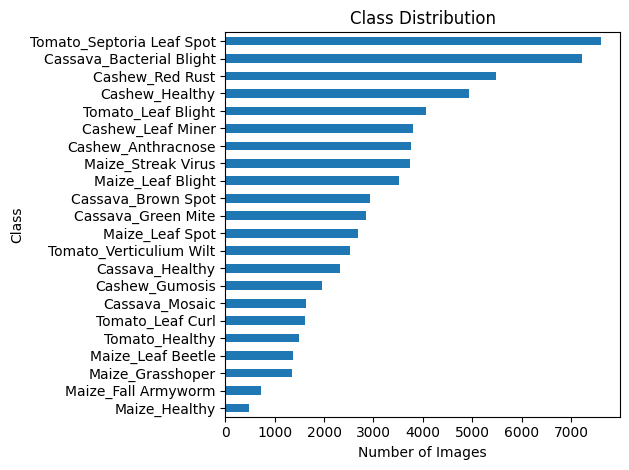


Class Distribution Statistics:
Total classes: 22
Average images per class: 3093.2
Median images per class: 2763.5
Most imbalanced classes:
                     count
Maize_Healthy          483
Maize_Fall Armyworm    720
Maize_Grasshoper      1356
Maize_Leaf Beetle     1375
Tomato_Healthy        1492

Largest classes:
                           count
Tomato_Leaf Blight          4073
Cashew_Healthy              4931
Cashew_Red Rust             5491
Cassava_Bacterial Blight    7214
Tomato_Septoria Leaf Spot   7613


<Figure size 1200x800 with 0 Axes>

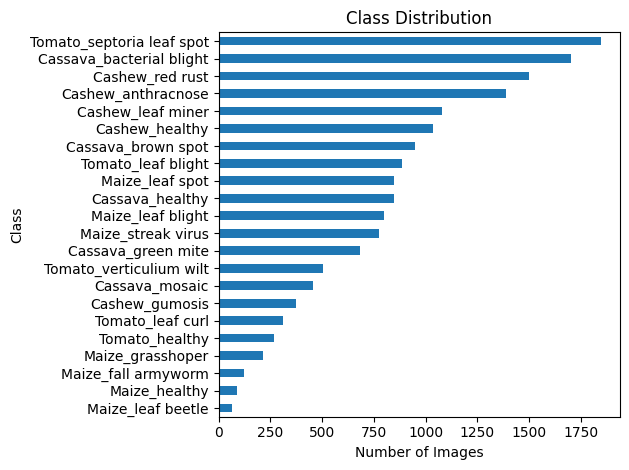


Class Distribution Statistics:
Total classes: 22
Average images per class: 761.6
Median images per class: 789.0
Most imbalanced classes:
                     count
Maize_leaf beetle       66
Maize_healthy           91
Maize_fall armyworm    123
Maize_grasshoper       216
Tomato_healthy         266

Largest classes:
                           count
Cashew_leaf miner           1077
Cashew_anthracnose          1390
Cashew_red rust             1499
Cassava_bacterial blight    1704
Tomato_septoria leaf spot   1846


In [ ]:
def analyze_class_distribution(dataset_path):
    class_counts = {}

    for crop in os.listdir(dataset_path):
        crop_path = os.path.join(dataset_path, crop)
        if not os.path.isdir(crop_path):
            continue

        for disease in os.listdir(crop_path):
            disease_path = os.path.join(crop_path, disease)
            if not os.path.isdir(disease_path):
                continue

            num_images = len([f for f in os.listdir(disease_path)
                           if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_name = f"{crop}_{disease}"
            class_counts[class_name] = num_images

    # Create dataframe and sort
    df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count'])
    df = df.sort_values('count')

    # Plot distribution
    plt.figure(figsize=(12, 8))
    df.plot(kind='barh', legend=False)
    plt.title('Class Distribution')
    plt.xlabel('Number of Images')
    plt.ylabel('Class')
    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nClass Distribution Statistics:")
    print(f"Total classes: {len(df)}")
    print(f"Average images per class: {df['count'].mean():.1f}")
    print(f"Median images per class: {df['count'].median()}")
    print(f"Most imbalanced classes:")
    print(df.head(5))  # Smallest classes
    print("\nLargest classes:")
    print(df.tail(5))  # Largest classes

    return df

# Usage
class_distribution_augmented = analyze_class_distribution("Filtered_Augmented_Dataset")
class_distribution_raw = analyze_class_distribution("Filtered_Raw_Dataset")

In [ ]:
# Remove Merged_Crop_Augmented_Data folder
if os.path.exists('/content/Merged_Crop_Augmented_Data'):
    shutil.rmtree('/content/Merged_Crop_Augmented_Data')

# Remove Crop_Raw_Data folder
if os.path.exists('/content/Crop_Raw_Data'):
    shutil.rmtree('/content/Crop_Raw_Data')

In [ ]:
from google.colab import files
folder_path = ('/content/Filtered_Augmented_Dataset')
shutil.make_archive('/content/Filtered_Augmented_Dataset', 'zip', folder_path)
files.download('/content/Filtered_Augmented_Dataset.zip')

folder_Path = ('/content/Filtered_Raw_Dataset')
shutil.make_archive('/content/Filtered_Raw_Dataset', 'zip', folder_Path)
files.download('/content/Filtered_Raw_Dataset.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Balancing the two dataset (Augmented & Raw)

In [ ]:
def progress_loader(current, total, message="Processing"):
    percent = (current / total) * 100
    sys.stdout.write(f"\r{message}... {percent:.2f}%")
    sys.stdout.flush()

def balance_dataset(source_dir, target_dir, target_count=4500, augment_threshold=3000):
    """
    Balance dataset by copying, augmenting, or undersampling images.
    """
    os.makedirs(target_dir, exist_ok=True)

    datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='reflect'
    )

    crops = os.listdir(source_dir)
    total_crops = len(crops)

    for crop_idx, crop in enumerate(crops, 1):
        progress_loader(crop_idx, total_crops, message=f"Processing crop: {crop}")
        crop_path = os.path.join(source_dir, crop)
        target_crop_path = os.path.join(target_dir, crop)
        os.makedirs(target_crop_path, exist_ok=True)

        diseases = os.listdir(crop_path)
        total_diseases = len(diseases)

        for disease_idx, disease in enumerate(diseases, 1):
            progress_loader(disease_idx, total_diseases, message=f"Processing disease: {disease}")
            disease_path = os.path.join(crop_path, disease)
            target_disease_path = os.path.join(target_crop_path, disease)
            os.makedirs(target_disease_path, exist_ok=True)

            images = [f for f in os.listdir(disease_path)
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            num_images = len(images)


            if num_images == 0:
                continue


            if num_images < augment_threshold:

                for img in images:
                    shutil.copy2(os.path.join(disease_path, img),
                                os.path.join(target_disease_path, img))


                needed = target_count - num_images
                augmentation_factor = max(2, int(needed / num_images) + 1)

                for img_idx, img in enumerate(images, 1):
                    img_path = os.path.join(disease_path, img)
                    image = cv2.imread(img_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    total_aug = augmentation_factor
                    for aug_idx, batch in enumerate(datagen.flow(
                        image[np.newaxis, ...],
                        batch_size=1,
                        save_to_dir=target_disease_path,
                        save_prefix='aug',
                        save_format='jpg'
                    )):

                        progress_loader(aug_idx+1, total_aug, message=f"Augmenting {img}")
                        if aug_idx+1 >= total_aug:
                            break

            elif num_images < target_count:

                for img in images:
                    shutil.copy2(os.path.join(disease_path, img),
                                os.path.join(target_disease_path, img))

                needed = target_count - num_images
                sampled = random.sample(images, needed)
                total_samples = len(sampled)

                for sample_idx, img in enumerate(sampled, 1):
                    img_path = os.path.join(disease_path, img)
                    image = cv2.imread(img_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


                    progress_loader(sample_idx, total_samples, message=f"Augmenting sampled {img}")

                    for batch in datagen.flow(
                        image[np.newaxis, ...],
                        batch_size=1,
                        save_to_dir=target_disease_path,
                        save_prefix='aug',
                        save_format='jpg'
                    ):
                        break

            # --- Processing large classes (downsampling) ---
            else:
                # Randomly sample target_count images
                sampled = random.sample(images, target_count)
                for img in sampled:
                    shutil.copy2(os.path.join(disease_path, img),
                                os.path.join(target_disease_path, img))


balance_dataset(
    source_dir="Filtered_Augmented_Dataset",
    target_dir="Balanced_augmented_dataset_final",
    target_count=4500,        # Your median class size
    augment_threshold=3000    # Augment classes below this
)

balance_dataset(
    source_dir="Filtered_Raw_Dataset",
    target_dir="Balanced_raw_dataset_final",
    target_count=4500,        # Your median class size
    augment_threshold=3000    # Augment classes below this
)

In [ ]:
# Remove Filtered_Augmented_Dataset
if os.path.exists('/content/Filtered_Augmented_Dataset'):
    shutil.rmtree('/content/Filtered_Augmented_Dataset')

# Remove Filtered_Raw_Dataset
if os.path.exists('/content/Filtered_Raw_Dataset'):
    shutil.rmtree('/content/Filtered_Raw_Dataset')

## Image Resizing to fit the Chosen Model(Efficient Net)
This function preprocesses image datasets for EfficientNet models by resizing images to a specified target dimension (default 224×224) while maintaining aspect ratios and applying intelligent padding when needed. It recursively processes all common image formats (PNG, JPG, JPEG, WEBP) from the source directory while preserving the original folder structure.

The implementation first converts images to RGB format if needed, then calculates proportional dimensions to maintain aspect ratios using high-quality Lanczos resampling. When the resized image doesn't match the target dimensions exactly, it automatically adds symmetrical white padding to reach the required size. For JPEG files, it applies customizable compression quality (default 95), while optimizing file sizes for all formats.

The function includes robust error handling to skip problematic files without interrupting the batch process, and features a progress bar via tqdm for monitoring large operations. Designed specifically for EfficientNet input requirements, it creates pixel-perfect square images that work optimally with these models while minimizing distortion through its aspect ratio-preserving approach.

In [ ]:

def resize_for_efficientnet(dataset_dir, output_dir, target_size=224, quality=95):
    """
    Optimized image resizer for EfficientNet that:
    - Maintains aspect ratio
    - Adds minimal padding when needed
    - Preserves directory structure
    - Handles various image formats

    Args:
        dataset_dir: Input directory with original images
        output_dir: Where to save resized images
        target_size: Target dimension (380 for EfficientNet)
        quality: JPEG quality (1-100)
    """
    # Create output directory if needed
    os.makedirs(output_dir, exist_ok=True)

    # Supported image formats
    img_extensions = ('.png', '.jpg', '.jpeg', '.webp')

    # Process all images
    for root, _, files in tqdm(os.walk(dataset_dir), desc="Processing images"):
        for file in files:
            if not file.lower().endswith(img_extensions):
                continue

            input_path = os.path.join(root, file)
            rel_path = os.path.relpath(input_path, dataset_dir)
            output_path = os.path.join(output_dir, rel_path)

            # Create output directory structure
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            try:
                with Image.open(input_path) as img:
                    # Convert to RGB if needed
                    if img.mode != 'RGB':
                        img = img.convert('RGB')

                    # Calculate new dimensions maintaining aspect ratio
                    width, height = img.size
                    scale = target_size / max(width, height)
                    new_size = (int(width * scale), int(height * scale))

                    # Resize with high-quality downsampling
                    img = img.resize(new_size, Image.Resampling.LANCZOS)

                    # Add padding if needed (maintains 380x380)
                    if new_size != (target_size, target_size):
                        delta_w = target_size - new_size[0]
                        delta_h = target_size - new_size[1]
                        padding = (delta_w//2, delta_h//2,
                                  delta_w-(delta_w//2), delta_h-(delta_h//2))
                        img = ImageOps.expand(img, padding, fill=(255, 255, 255))

                    # Save with optimized settings
                    if output_path.lower().endswith(('.jpg', '.jpeg')):
                        img.save(output_path, quality=quality, optimize=True)
                    else:
                        img.save(output_path, optimize=True)

            except Exception as e:
                print(f"\nError processing {input_path}: {str(e)}")
                continue

    print("\nResizing complete!")



resize_for_efficientnet(
    dataset_dir="Balanced_augmented_dataset_final",
    output_dir="EfficientNet_380_augmented_dataset",
    target_size=380,
    quality=95
)

resize_for_efficientnet(
    dataset_dir="Balanced_raw_dataset_final",
    output_dir="EfficientNet_380_raw_dataset",
    target_size=380,
    quality=95
)

In [ ]:
from google.colab import files
folder_path = ('/content/EfficientNet_380_augmented_dataset')
shutil.make_archive('/content/EfficientNet_380_augmented_dataset', 'zip', folder_path)


folder_Path = ('/content/EfficientNet_380_raw_dataset')
shutil.make_archive('/content/EfficientNet_380_raw_dataset', 'zip', folder_Path)



In [ ]:
# Remove Balanced_augmented_dataset_final
if os.path.exists('/content/Balanced_augmented_dataset_final'):
    shutil.rmtree('/content/Balanced_augmented_dataset_final')

# Remove Balanced_raw_dataset_final
if os.path.exists('/content/Balanced_raw_dataset_final'):
    shutil.rmtree('/content/Balanced_raw_dataset_final')

#### Dataset Splits

In [ ]:

def split_dataset(input_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, image_exts=('jpg', 'jpeg', 'png')):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"

    if not os.path.exists(input_dir):
        raise FileNotFoundError(f"❌ Input directory '{input_dir}' does not exist.")

    # Clear output_dir
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    # Recursively find all leaf folders with image files
    class_folders = []
    for root, dirs, files in os.walk(input_dir):
        image_files = [f for f in files if f.lower().endswith(image_exts)]
        if image_files:
            class_folders.append((root, image_files))

    if not class_folders:
        raise ValueError(f"⚠️ No image-containing class folders found in '{input_dir}'.")

    for folder_path, image_files in class_folders:
        # Create class label from nested folder structure
        relative_path = os.path.relpath(folder_path, input_dir)
        class_name = relative_path.replace(os.sep, "_")  # e.g. Tomato/Leaf_Blight → Tomato_Leaf_Blight

        print(f"📂 Processing class '{class_name}' with {len(image_files)} images...")

        # Split images
        train_imgs, temp_imgs = train_test_split(image_files, train_size=train_ratio, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_ratio / (val_ratio + test_ratio), random_state=42)

        for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)

            for img_name in split_imgs:
                src = os.path.join(folder_path, img_name)
                dst = os.path.join(split_class_dir, img_name)
                shutil.copy2(src, dst)

            print(f"   ✅ {split}: {len(split_imgs)} images")

    print("\n✅ Dataset successfully split into 'train', 'val', and 'test' folders.")

split_dataset(
    input_dir="Filtered_Augmented_Dataset",
    output_dir="EfficientNet_380_augmented_split_dataset",
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1
)

split_dataset(
    input_dir="Filtered_Raw_Dataset",
    output_dir="EfficientNet_380_raw_split_dataset",
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1
)

📂 Processing class 'Tomato_Septoria Leaf Spot' with 7613 images...
   ✅ train: 6090 images
   ✅ val: 761 images
   ✅ test: 762 images
📂 Processing class 'Tomato_Leaf Curl' with 1610 images...
   ✅ train: 1288 images
   ✅ val: 161 images
   ✅ test: 161 images
📂 Processing class 'Tomato_Leaf Blight' with 4073 images...
   ✅ train: 3258 images
   ✅ val: 407 images
   ✅ test: 408 images
📂 Processing class 'Tomato_Healthy' with 1492 images...
   ✅ train: 1193 images
   ✅ val: 149 images
   ✅ test: 150 images
📂 Processing class 'Tomato_Verticulium Wilt' with 2519 images...
   ✅ train: 2015 images
   ✅ val: 252 images
   ✅ test: 252 images
📂 Processing class 'Maize_Fall Armyworm' with 720 images...
   ✅ train: 576 images
   ✅ val: 72 images
   ✅ test: 72 images
📂 Processing class 'Maize_Grasshoper' with 1356 images...
   ✅ train: 1084 images
   ✅ val: 136 images
   ✅ test: 136 images
📂 Processing class 'Maize_Leaf Beetle' with 1375 images...
   ✅ train: 1100 images
   ✅ val: 137 images
   ✅ t

In [ ]:
# Remove EfficientNet_380_augmented_dataset
if os.path.exists('/content/EfficientNet_380_augmented_dataset'):
    shutil.rmtree('/content/EfficientNet_380_augmented_dataset')

# Remove EfficientNet_380_raw_dataset
if os.path.exists('/content/EfficientNet_380_raw_dataset'):
    shutil.rmtree('/content/EfficientNet_380_raw_dataset')

# Merge Augmented and Raw Dataset Splits

In [ ]:
def merge_splits(augmented_dir, raw_dir, output_dir):
    splits = ['train', 'val', 'test']
    os.makedirs(output_dir, exist_ok=True)

    for split in splits:
        combined_split_dir = os.path.join(output_dir, split)
        os.makedirs(combined_split_dir, exist_ok=True)

        # Directories for augmented and raw
        augmented_split = os.path.join(augmented_dir, split)
        raw_split = os.path.join(raw_dir, split)

        # Merge each class folder from augmented
        if os.path.exists(augmented_split):
            for class_folder in os.listdir(augmented_split):
                class_path = os.path.join(augmented_split, class_folder)
                target_class_path = os.path.join(combined_split_dir, class_folder)
                os.makedirs(target_class_path, exist_ok=True)
                for img in os.listdir(class_path):
                    src = os.path.join(class_path, img)
                    dst = os.path.join(target_class_path, img)
                    shutil.copy2(src, dst)

        # Merge each class folder from raw
        if os.path.exists(raw_split):
            for class_folder in os.listdir(raw_split):
                class_path = os.path.join(raw_split, class_folder)
                target_class_path = os.path.join(combined_split_dir, class_folder)
                os.makedirs(target_class_path, exist_ok=True)
                for img in os.listdir(class_path):
                    src = os.path.join(class_path, img)
                    dst = os.path.join(target_class_path, img)
                    shutil.copy2(src, dst)

        print(f"Merged {split} splits into {combined_split_dir}")


augmented_split_dir = "EfficientNet_380_augmented_split_dataset"
raw_split_dir = "EfficientNet_380_raw_split_dataset"
merged_output_dir = "EfficientNet_380_dataset"

merge_splits(augmented_split_dir, raw_split_dir, merged_output_dir)
print("Merging completed successfully!")

In [ ]:
# Remove EfficientNet_380_augmented_split_dataset
if os.path.exists('/content/EfficientNet_380_augmented_split_dataset'):
    shutil.rmtree('/content/EfficientNet_380_augmented_split_dataset')

# Remove EfficientNet_380_raw_split_dataset
if os.path.exists('/content/EfficientNet_380_raw_split_dataset'):
    shutil.rmtree('/content/EfficientNet_380_raw_split_dataset')

# Checking Validity of Images(Takes out corrupt files)

In [ ]:
import os
from PIL import Image, UnidentifiedImageError

def get_all_image_paths(dataset_path):
    image_paths = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

def validate_images(image_paths):
    """Check each image for validity and identify corrupted ones"""
    corrupted_files = []
    for path in image_paths:
        try:
            with Image.open(path) as img:
                img.verify()  # verify image data
        except (IOError, SyntaxError, UnidentifiedImageError):
            print(f"Invalid or corrupted image: {path}")
            corrupted_files.append(path)
    return corrupted_files

# Dataset path
dataset_root = "EfficientNet_224_dataset"

# Gather all images from train, val, and test folders
train_images = get_all_image_paths(os.path.join(dataset_root, "train"))
val_images = get_all_image_paths(os.path.join(dataset_root, "val"))
test_images = get_all_image_paths(os.path.join(dataset_root, "test"))

# Combine all paths
all_images = train_images + val_images + test_images

# Validate images
corrupted_files = validate_images(all_images)

# Remove corrupted files
for file_path in corrupted_files:
    print(f"Removing corrupted image: {file_path}")
    os.remove(file_path)

print(f"Finished validation. Removed {len(corrupted_files)} corrupted files.")

#Model Setup & Training

In [ ]:


# Paths to image directories
train_dir = "EfficientNet_224_dataset/train"
val_dir = "EfficientNet_224_dataset/val"
test_dir = "EfficientNet_224_dataset/test"

# Image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32

# Enhanced data augmentation with more transformations for extra validation

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Computing the class weights (if dataset is imbalanced)
class_indices = train_generator.class_indices
labels = train_generator.classes

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))

# Loading our desired base model (EfficientNetB0)
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Adding a custom head for fine tuning

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(len(class_indices), activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=predictions)


# Making all layers trainable for comprehensive fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compiling the model with a low learning rate for our fine-tuning step
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# EarlyStopping if validation loss doesn't improve for 5 epochs in order to start debugging early
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ReduceLROnPlateau to alloq us reduce the learning rate by a factor of 0.1 if validation loss stalls for 3 epochs
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)

# ModelCheckpoint that saves the best model during training
checkpoint = ModelCheckpoint("efficientnetb0_finetuned.h5", save_best_only=True)


# Training the model

print("🔧 Starting training with increased epochs and enhanced callbacks...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Increased from 2 to 10
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr, checkpoint]
)



# Final Model Test

In [ ]:
if os.path.exists("efficientnetb0_finetuned 10_epochs1(19%).h5"):
    model.load_weights("efficientnetb0_finetuned 10_epochs1(19%).h5")
    test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
    print(f" Final Test Accuracy: {test_acc * 100:.2f}%")
else:
    print(" No best weights file found — skipping evaluation.")

# Performance Metrics


In [ ]:

if os.path.exists("efficientnetb0_finetuned.h5"):
    model.load_weights("efficientnetb0_finetuned.h5")
    print("Model weights loaded for performance evaluation.")
else:
    print("Model weights not found. Make sure to load your trained model.")

# Generate predictions for the test set
y_pred_prob = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

true_labels = test_generator.classes


class_labels = list(test_generator.class_indices.keys())

# Classification report
report = classification_report(true_labels, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

# Confusion matrix
cm = confusion_matrix(true_labels, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()